In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# Define ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Load CIFAR dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define ResNet model
net = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the network
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

# Save trained model
PATH = './resnet_cifar.pth'
torch.save(net.state_dict(), PATH)

# Test the network on test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)atd
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


/home/akiyama/.conda/envs/base310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 170498071/170498071 [01:12<00:00, 2362892.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[1,   200] loss: 1.761
[1,   400] loss: 1.381
[1,   600] loss: 1.218
[2,   200] loss: 0.935
[2,   400] loss: 0.888
[2,   600] loss: 0.843
[3,   200] loss: 0.638
[3,   400] loss: 0.630
[3,   600] loss: 0.637
[4,   200] loss: 0.418
[4,   400] loss: 0.449
[4,   600] loss: 0.469
[5,   200] loss: 0.260
[5,   400] loss: 0.272
[5,   600] loss: 0.307
[6,   200] loss: 0.143
[6,   400] loss: 0.141
[6,   600] loss: 0.170
[7,   200] loss: 0.097
[7,   400] loss: 0.094
[7,   600] loss: 0.116
[8,   200] loss: 0.081
[8,   400] loss: 0.059
[8,   600] loss: 0.073
[9,   200] loss: 0.041
[9,   400] loss: 0.036
[9,   600] loss: 0.030
[10,   200] loss: 0.024
[10,   400] loss: 0.019
[10,   600] loss: 0.017
Finished Training
Accuracy of the network on the 10000 test images: 77 %


Files already downloaded and verified
Predicted labels for the three samples:
Sample 1: Predicted class cat
Sample 2: Predicted class truck
Sample 3: Predicted class airplane


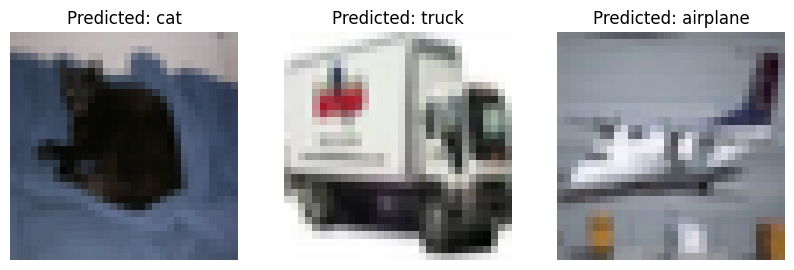

In [25]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get three random samples from the test dataset
sample_indices = np.random.choice(len(testset), 3, replace=False)
sample_images = torch.stack([testset[i][0] for i in sample_indices]).to(device)
sample_labels = [testset[i][1] for i in sample_indices]

# Perform inference
outputs = net(sample_images)

# Get predicted labels
_, predicted = torch.max(outputs, 1)

# Print predicted labels
print('Predicted labels for the three samples:')
for i in range(len(sample_images)):
    predicted_class = class_names[predicted[i]]
    print('Sample %d: Predicted class %s' % (i+1, predicted_class))

# Plot the images with their predicted labels
plt.figure(figsize=(10, 5))
for i in range(len(sample_images)):
    img = sample_images[i].cpu() / 2 + 0.5  # unnormalize and move to CPU
    npimg = img.numpy()
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Predicted: %s' % class_names[predicted[i]])
    plt.axis('off')
plt.show()